## Discrete-time state-space neural networks: a special recurrent network architecture 

While neural ordinary differential equations (NODEs) describe systems' dynamics in the continuous-time domain and, therefore, require the integration of numerical ODE solvers to obtain a system response solution, one can also utilize an artificial neural network (ANN) to describe the right-hand side of the discrete-time state-space model:
$\begin{align}\hat{x}[k+1] &= f_w(\hat{x}[k], u[k]), \quad x[0]=x_0, \notag\\ \hat{y}[k] &= g_w(\hat{x}[k], u[k]).\notag\end{align}$ Here, $f_w(\cdots)$ and $g_w(\cdots)$ are ANN-based representations of the true system dynamics. Assuming an equidistant time grid with the sampling indices $k$ and the sampling interval $\Delta t$, this enables us to directly model the discrete-time system behavior without the need of integrating an ODE solver since we model the discrete-time system response solution based on a difference equation.

### Thermal behavior of a DC-motor

In this notebook, we will re-utilize the previous [DC-motor temperature example](Hammerstein_Temperature_Motor.ipynb) using a Hammerstein ground truth model:
$$\frac{\mathrm{d}}{\mathrm{d}t}x(t) = \frac{1}{C_\mathrm{Th}}\left(\frac{\vartheta_\mathrm{A}(t)-x(t)}{R_\mathrm{Th}} + P_\mathrm{v}(u(t), x(t))\right).$$

In [35]:
using OrdinaryDiffEq, Lux, Random, ComponentArrays, Plots, BenchmarkTools, StatsBase, LaTeXStrings, Statistics
using Parameters: @unpack
using SciMLSensitivity, Optimization, Zygote, OptimizationFlux, LinearAlgebra

In [36]:
function simple_motor_temperature_model(dx, x, p, t)
    i(t)    = p[1](t); # motor current (time-dependent function)
    n(t)    = p[2](t); # motor speed (time-dependent function)
    ϑ_A(t)  = p[3](t); # ambient temperature (time-dependent function)
    R_Cu(t) = p[4] * (1 + p[5] * (x[1] - 20)) # copper resistance (temperature dependent with room temperature as reference)
    R_Fe(t) = p[6] * (1 + p[7] * (x[1] - 20)) # iron resistance (temperature dependent with room temperature as reference)
    L       = p[8] # inductance

    Pv(t)  = i(t)^2 * R_Cu(t) + (L * i(t) * n(t)/60*2*pi)^2 / R_Fe(t) # power loss in the motor
    
    dx[1]  = 1 / p[9] * ((-x[1] + ϑ_A(t)) / p[10] + Pv(t)) # temperature dynamics
end;

In [37]:
i = t -> Float32(125 + 50*sin(2*pi*t/60) + 60*sin(2*pi*t/300)) # motor current (time-dependent function)
n = t -> Float32(1000 + 100*cos(2*pi*t/100) + 500*cos(2*pi*t/1000)) # motor speed (time-dependent function)
ϑ_A = t -> Float32(20 + 2*sin(2*pi*t/2000)) # ambient temperature (time-dependent function)
p_ODE = (i, n, ϑ_A, 0.016, 0.0039, 5000.0, 0.00651, 0.05, 1400.0, 0.17); # true parameters (tuple)

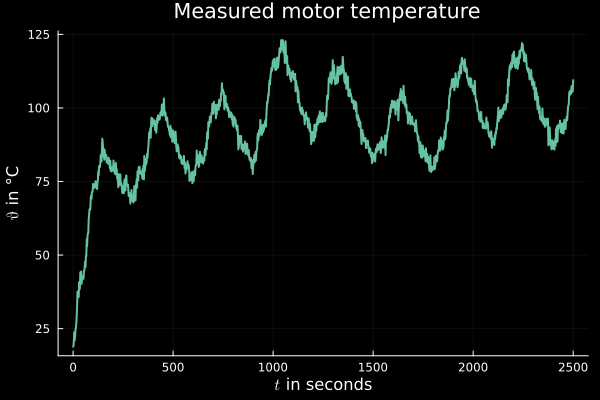

In [38]:
x0 = [20]   # initial temperature
dt = 2.0f0  # sampling time
tspan = (0.0, 2500.0) # simulation time span

prob = ODEProblem(simple_motor_temperature_model, x0, tspan, p_ODE) # define ODE problem
sol = solve(prob, Tsit5(), saveat=dt); # solve ODE problem

t = sol.t # time vector 
x = reduce(vcat,sol.u) # temperature vector
y = x .+ 1.5*randn(size(x)); # measured temperature vector incl. additive noise  

# plot results
plot(t, y, title=" Measured motor temperature", xlabel=L"$t$ in seconds", ylabel=L"$\vartheta$ in °C", 
    background_color="#000000",lw=2, palette = :Set2_5, legend = false)

### Discrete-time black-box style modeling approach

In contrast to the previous NODE example for the given modeling problem, we will utilize a more black-box style approach in this example, that is, we will not incorporate further system pre-knowledge in terms of the right-hand side structure: $$ \hat{x}[k+1] = f_w(\hat{x}[k], i[k], n[k], \vartheta_{\mathrm{A}}[k]), \quad x[0]=x_0. $$ Here, $i[k], n[k], \vartheta_{\mathrm{A}}[k]$ are the motor current, speed as well as the ambient temperature and $\hat{x}[k]$ is the estimate of the motor's internal temperature as the model's state. As we do directly measure the motor's temperature (not counting for measurement noise), we do not need to model the nonlinear output / measurement equation $g_w(\cdots)$.


Configure the training simulation framework:

In [39]:
NF = Float32 
x0_NODE = [NF.(y[1])] # initial temperature
tspan_NODE = NF.(tspan) # simulation time span
datasize = Int(tspan_NODE[2]/dt+1) # number of data points
tsteps_NODE = range(tspan_NODE[1], tspan_NODE[2]; length=datasize); # time vector 

Obtain training data on a discrete-time grid and standardize the data. Due to the black box character of the model, this data pre-processing is of particular importance. 

In [40]:
i_vec = map(x -> i(x), tsteps_NODE) # current vector
n_vec = map(x -> n(x), tsteps_NODE) # speed vector
ϑ_A_vec = map(x -> ϑ_A(x), tsteps_NODE); # ambient temperature vector

tf_i_vec = fit(ZScoreTransform, i_vec) # fit Z-score transformation to current vector
tf_n_vec = fit(ZScoreTransform, n_vec) # fit Z-score transformation to speed vector
tf_ϑ_A_vec = fit(ZScoreTransform, ϑ_A_vec) # fit Z-score transformation to ambient temperature vector
tf_y = fit(ZScoreTransform, y) # fit Z-score transformation to measured temperature vector

i_vec_norm = NF.(StatsBase.transform(tf_i_vec, i_vec)) # normalized current vector
n_vec_norm = NF.(StatsBase.transform(tf_n_vec, n_vec)) # normalized speed vector
ϑ_A_vec_norm = NF.(StatsBase.transform(tf_ϑ_A_vec, ϑ_A_vec)); # normalized ambient temperature vector
y_norm = NF.(StatsBase.transform(tf_y, y)); # normalized measured temperature vector

y_mean = NF.(tf_y.mean[1]) # mean of measured temperature vector
y_scale = NF.(tf_y.scale[1]); # scale of measured temperature vector   

Next, we set up the right-hand side of the discrete-time state-space model by a simple, low-order ANN without any hidden layer. We utilize a `tan()` output layer activation to enable positive as well as negative changes of the standardized temperature state between two time steps. Moreover, we scale down the initialized ANN's weight values via the keyword `gain = 0.05` such that the expected standardized temperature change per time step (which is the output of the ANN as the right-hand side of the state-space difference equation) becomes not unfeasible large during the starting phase of the training.

In [52]:
ann_DE = Lux.Chain(Lux.Dense(4, 10, tanh; init_weight=glorot_uniform(;gain = 0.05)), Lux.Dense(10, 1, tanh; init_weight=glorot_uniform(;gain = 0.05))); # define neural network architecture
w_DE, st_DE =Lux.setup(MersenneTwister(140588), ann_DE); # initialize neural network parameters and state
w_DE = ComponentArray(w_DE); # initial guess parameters for difference equation approach (ComponentArray)

In [53]:
p_DE = (y_norm, i_vec_norm, n_vec_norm, ϑ_A_vec_norm, y_mean, y_scale); 

For the loss function, we need to take care of defining it in a non-mutating fashion to enable algorithmic differentiation later on.

In [54]:
function loss_DE(w, p)
    y_norm, i_vec_norm, n_vec_norm, ϑ_A_vec_norm, y_mean, y_scale = p
    x = y_norm[1] # initial temperature
    loss = zero(eltype(w)) # initialize loss function
    for ii = 2:length(y)
        x += ann_DE([i_vec_norm[ii-1]; n_vec_norm[ii-1]; ϑ_A_vec_norm[ii-1]; x], w, st_DE)[1][1] # difference equation approach
        loss += abs2(y_norm[ii] - x) # loss function
    end
    return loss
end;

In [55]:
function predict_DE(w, p)
    y_norm, i_vec_norm, n_vec_norm, ϑ_A_vec_norm, y_mean, y_scale = p
    x_hat = zeros(eltype(w), length(y_norm))
    x_hat[1] = y_norm[1]
    for ii = 2:length(y_norm)
        x_hat[ii] = x_hat[ii-1] + ann_DE([i_vec_norm[ii-1]; n_vec_norm[ii-1]; ϑ_A_vec_norm[ii-1]; x_hat[ii-1]], w, st_DE)[1][1]
    end
    return x_hat
end;

Define the optimization problem to identify the parameters of the black-box model.

In [56]:
adtype = Optimization.AutoZygote()
optf_DE = Optimization.OptimizationFunction(loss_DE, adtype)
optprob_DE = Optimization.OptimizationProblem(optf_DE, w_DE, p_DE);

In [57]:
losses = Float32[]
callback_online = function (p, l)
    push!(losses, l)
    if length(losses) % 50 == 0
        println("Current loss after $(length(losses)) iterations: $(losses[end])")
    end
    return false
end;

Solve the optimization problem.

In [58]:
res_DE = Optimization.solve(optprob_DE, Adam(0.01);   maxiters=1000, maxtime = 120.0, callback=callback_online);

Current loss after 50 iterations: 766.3473


Current loss after 100 iterations: 331.507


Current loss after 150 iterations: 299.75684


Current loss after 200 iterations: 260.31204


Current loss after 250 iterations: 211.1476


Current loss after 300 iterations: 152.14134


Current loss after 350 iterations: 88.270485


Current loss after 400 iterations: 39.78855


Current loss after 450 iterations: 26.0736


Current loss after 500 iterations: 25.410332


Current loss after 550 iterations: 25.290705


Current loss after 600 iterations: 25.148869


Current loss after 650 iterations: 24.974863


Current loss after 700 iterations: 24.75553


Current loss after 750 iterations: 24.4735


Current loss after 800 iterations: 24.106936


Current loss after 850 iterations: 23.632164


Current loss after 900 iterations: 23.02954


Current loss after 950 iterations: 22.293633


Current loss after 1000 iterations: 21.445261


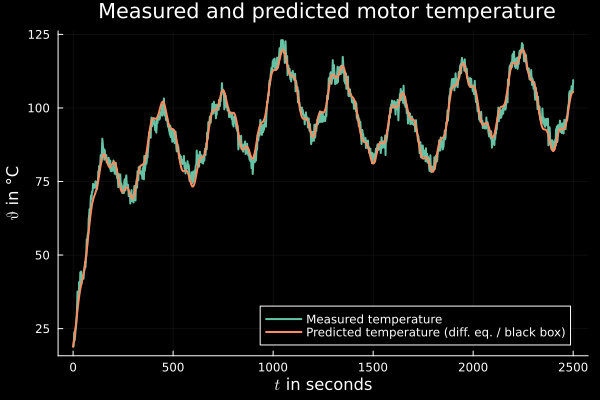

In [59]:
plot(tsteps_NODE, y, title=" Measured and predicted motor temperature", 
    xlabel=L"$t$ in seconds", ylabel=L"$\vartheta$ in °C", background_color="#000000", 
    lw=2, palette = :Set2_5, label = "Measured temperature")
plot!(tsteps_NODE, StatsBase.reconstruct(tf_y, predict_DE(res_DE.u, p_DE)), label="Predicted temperature (diff. eq. / black box)", lw=2)

### Adding some expert features

Although the previous black-box modeling attempt delivered decent results, the found accuracy is not as great as with the [NODE approach](Hammerstein_Temperature_Motor.ipynb). As a step towards integrating some minimal a priori knowledge about the system without adding structural constraints on the right-hand side representation of the state-space difference equation, we can change our input features. In particular, we will make use of the input features $$\{i^2[k], \quad (i[k]*n[k])^2\}$$ instead of just the barebone input signals $\{i[k], n[k]\}$, assuming that we know that those new features are highly-related to the power loss behavior of the motor.  

Let's define the new input features and pre-process the according data.

In [60]:
i_sqr_vec = map(x -> i(x).^2, tsteps_NODE) # squared current vector
in_sqr_vec = map(x -> i(x).^2 .* n(x).^2, tsteps_NODE); # squared current times speed vector

tf_in_sqr_vec = fit(ZScoreTransform, in_sqr_vec) # fit Z-score transformation to squared current times speed vector
tf_i_sqr_vec = fit(ZScoreTransform, i_sqr_vec) # fit Z-score transformation to squared current vector

in_sqr_vec_norm = NF.(StatsBase.transform(tf_in_sqr_vec, in_sqr_vec)) # normalized squared current times speed vector
i_sqr_vec_norm = NF.(StatsBase.transform(tf_i_sqr_vec, i_sqr_vec)); # normalized squared current vector

We reformulate our optimization problem, using the feature vector `_p_pde()` with the new input features.

In [61]:
losses = Float32[]
_p_DE = (y_norm, i_sqr_vec_norm, in_sqr_vec_norm, ϑ_A_vec_norm, y_mean, y_scale); 
_optprob_DE = Optimization.OptimizationProblem(optf_DE, w_DE, _p_DE);
_res_DE = Optimization.solve(_optprob_DE, Adam(0.01);   maxiters=1000, maxtime = 120.0, callback=callback_online);

Current loss after 50 iterations: 765.4456


Current loss after 100 iterations: 332.95752


Current loss after 150 iterations: 298.74124


Current loss after 200 iterations: 255.19774


Current loss after 250 iterations: 200.10968


Current loss after 300 iterations: 133.55418


Current loss after 350 iterations: 64.34502


Current loss after 400 iterations: 21.873232


Current loss after 450 iterations: 15.182049


Current loss after 500 iterations: 15.067609


Current loss after 550 iterations: 15.03033


Current loss after 600 iterations: 14.991961


Current loss after 650 iterations: 14.952566


Current loss after 700 iterations: 14.912295


Current loss after 750 iterations: 14.871264


Current loss after 800 iterations: 14.829601


Current loss after 850 iterations: 14.787409


Current loss after 900 iterations: 14.744816


Current loss after 950 iterations: 14.701812


Current loss after 1000 iterations: 14.658577


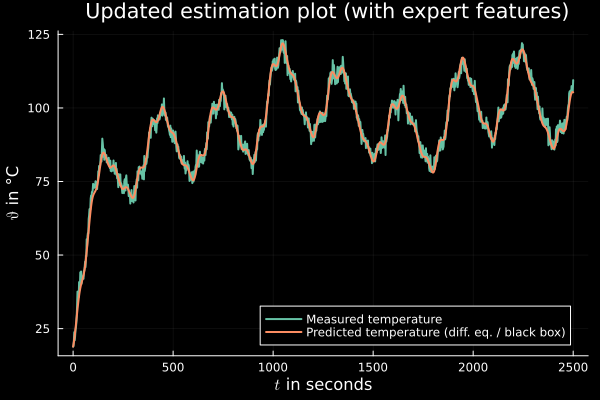

In [62]:
plot(tsteps_NODE, y, title=" Updated estimation plot (with expert features)", 
    xlabel=L"$t$ in seconds", ylabel=L"$\vartheta$ in °C", background_color="#000000", 
    lw=2, palette = :Set2_5, label = "Measured temperature")
plot!(tsteps_NODE, StatsBase.reconstruct(tf_y, predict_DE(_res_DE.u, _p_DE)), label="Predicted temperature (diff. eq. / black box)", lw=2)

With these expert features the estimation accuracy could be further improved and is on eye level with the previous NODE attempt, which **highlights the importance of well-chosen features within the data-driven modeling process of dynamical systems**. Comparing the black-box style difference-equation to the grey-box style NODE approach, we can summarize the following main differences:

- The NODE model delivers an ODE which can be solved for arbitrary time grids, which represents a certain flexibility. In contrast, the direct discrete-time modeling is fixed to the time stepping used during the identification process.
- The black-box discrete-time model did perform well even though we did not add structural pre-knowledge to the right-hand side equation. However, this is an anecdotal observation for the specific modeling problem which cannot be generalized (other, more complex systems will certainly require more structural pre-knowledge to enable converging into suitable solutions).
- The black-box approach also comes at the costs of lacking interpretability of the found solution. In the NODE approach, we obtained a high-level of interpretability due to the utilized heat equation structure, which allowed us inspecting important intermediate quantities such as the power losses, which is not possible in the utilized approach from this notebook.